Code Devised From -
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Import libraries

For Adilina - dataset is in UdG Account

For Anwai - dataset is in UdG Account

In [ ]:
import os
import glob
import random
import skimage
import imageio
import matplotlib
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

import scipy.ndimage
from scipy import misc, stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

import torch
import torchvision
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms

%matplotlib inline
%pip install barbar 
%pip install --upgrade efficientnet-pytorch
from barbar import Bar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

from google.colab import drive
drive._mount('/content/drive')

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=e061d9f2f6fc4a207bffd00b53903ea4b828568a36e0e9875290189017de590e
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch
Mounted at /content/drive


## Configuration Options and Hyper Parameters

In [ ]:
# Directories of the HAM10000 Dataset 
main_dir  = '/content/drive/MyDrive/CAD/Project - 2/Challenge 2/'
train_dir = main_dir + 'data/train/'
val_dir   = main_dir + 'data/val/'
# test_dir  = main_dir + 'data/test/'

# Classes of the Challenge 1
classes   = ['nv', 'ls']

# Normalization Mean and Standard Deviation Values for the Pretrained Weights on Imagenet Dataset
norm_mean = (0.485, 0.456, 0.406)
norm_std  = (0.229, 0.224, 0.225)

# Hyperparameters
num_size              = n # where n is the batch size you want, either the same for all the datasets or your individual choices.
batch_size            = num_size
validation_batch_size = num_size
test_batch_size       = num_size

num_epochs            = 100
num_classes           = len(classes)
learning_rate         = 1e-5
patience              = 10

# Image Size
height                = 450
width                 = 600

# Dimension of the CenterCrop Transformation (448,224,256)
centercrop            = c # depends on the configuration you prefer

## Data Augmentation

In [ ]:
# Specifying the Transformations for the Training Images
transform_train = transforms.Compose([
                    transforms.Resize((height,width)),
                    transforms.CenterCrop(centercrop),
                    transforms.RandomAffine(90,shear=20,scale=(0.8,1.2)),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomHorizontalFlip(),
                    transforms.ColorJitter(brightness=(0.7,1.3), contrast=(0.7,1.3), saturation=(0.7,1.3)),
                    # transforms.RandomRotation(degrees=90),
                    # transforms.RandomInvert(),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

# Specifying the Transformations for the Validation Images
transform_val = transforms.Compose([
                    transforms.Resize((height,width)),
                    transforms.CenterCrop(centercrop),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

# Specifying the Transformations for the Testing Images
transform_test = transforms.Compose([
                    transforms.Resize((height,width)),
                    transforms.CenterCrop(centercrop),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

Data Generators

In [ ]:
# Datasets
traindataset = torchvision.datasets.ImageFolder(root = train_dir, transform = transform_train)
valdataset   = torchvision.datasets.ImageFolder(root = val_dir, transform = transform_val)
# testdataset  = torchvision.datasets.ImageFolder(root = test_dir, transform = transform_test)

# Dataloaders
train_data_loader      = torch.utils.data.DataLoader(traindataset, batch_size = batch_size, shuffle = True)
validation_data_loader = torch.utils.data.DataLoader(valdataset, batch_size = validation_batch_size, shuffle = False)
# test_data_loader       = torch.utils.data.DataLoader(testdataset, batch_size = test_batch_size, shuffle = False)

Visualising the Transformation Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


   nv,     nv,     nv, 


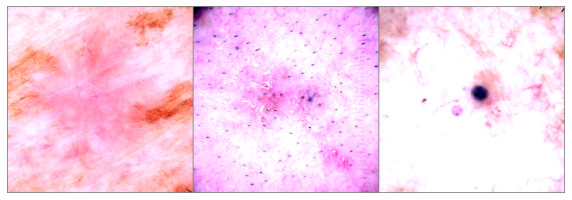

In [ ]:
# Function to Show Image
fig = plt.figure(figsize=(10, 15))
def imshow(img):
    img = img / 2 + 0.5     # unnormalise
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Obtain Random Training Images
dataiter       = iter(validation_data_loader)
images, labels = dataiter.next()

# Show the Images
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

## Architecture

In [ ]:
# Viewing the Architecture and Finding the Cross-Section of Transfer Learning
dummy_net = torchvision.models.googlenet(pretrained = True) 
print(dummy_net)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
# Alexnet Final Layers Sample - How to Play with them in the Necessary Structure
"""(classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=4096, out_features=1000, bias=True)"""

'(classifier): Sequential(\n    (0): Dropout(p=0.5, inplace=False)\n    (1): Linear(in_features=9216, out_features=4096, bias=True)\n    (2): ReLU(inplace=True)\n    (3): Dropout(p=0.5, inplace=False)\n    (4): Linear(in_features=4096, out_features=4096, bias=True)\n    (5): ReLU(inplace=True)\n    (6): Linear(in_features=4096, out_features=1000, bias=True)'

In [ ]:
# The Choice of our Architecture to Train
model = "googlenet"

# Replacing the Last Layer(s) of "x"net to Match our Number of Classes
net    = torchvision.models.googlenet(pretrained = True)
net.fc = nn.Linear(1024,num_classes)

print(net)
net = net.to(device)

# Number of Loops over the Dataset
model_save_dir = main_dir + 'pytorch-binary-models/try-cad1-checkpoint-epoch{0}-batchsize{1}-{2}.pt'.format(num_epochs, num_size, str(model))
print(model_save_dir)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
"""# If the model is to be used as a Feature Extractor, setting its parameters to non-trainable (by default, trainable)
for param in model.parameters():
    param.requires_grad = False"""

## Functions for Metrics and Validation Evaluation

In [ ]:
def get_accuracy(predicted, labels):
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_loader):
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy
    
class EarlyStopping:
    """Early Stops the Training if the Validation Loss doesn't improve after a predefined Patience."""
    def __init__(self, patience=7, verbose=False, delta=0):

        self.patience     = patience
        self.verbose      = verbose
        self.counter      = 0
        self.best_score   = None
        self.early_stop   = False
        self.val_loss_min = np.Inf
        self.delta        = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping Counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation Loss Decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), model_save_dir)
        self.val_loss_min = val_loss

## Training Progress

In [ ]:
# Clearing the GPU Cache
import torch
torch.cuda.empty_cache()

In [ ]:
load_checkpoint  = False
print("Starting Training with Network: " + model + ", Loading Checkpoint Status : " + str(load_checkpoint))

# Optimizer and Loss Configurations
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')

Starting Training with Network: googlenet, Loading Checkpoint Status : False


In [ ]:
if load_checkpoint == False:
  #net.load_state_dict(torch.load('/content/drive/MyDrive/CAD/Project - 2/Challenge 2/pytorch-binary-models/checkpoint-epoch-{0}.pt'.format(num_epochs)))
  #print("Here")
  
  # Initializing the early_stopping
  early_stopping = EarlyStopping(patience=patience, verbose=True)

  accuracy      = []
  val_accuracy  = []
  losses        = []
  val_losses    = []
  best_accuracy = 0

  for epoch in range(num_epochs):
      running_loss      = 0.0
      correct_total     = 0.0
      num_samples_total = 0.0
      for i, data in enumerate(Bar(train_data_loader)):
          # Getting the Inputs
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Setting the Parameter Gradients to Zero
          optimizer.zero_grad()

          # Forward Pass + Backward Pass + Optimize
          outputs = net(inputs)
          loss    = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          
          # Computing Accuracy
          _, predicted = torch.max(outputs, 1)
          b_len, corr = get_accuracy(predicted, labels)
          num_samples_total +=b_len
          correct_total +=corr
          running_loss += loss.item()

      running_loss /= len(train_data_loader)
      train_accuracy = correct_total/num_samples_total
      val_loss, val_acc = evaluate(net, validation_data_loader)
      scheduler.step(val_loss)
      
      print('Epoch: %d' %(epoch+1))
      print('Training Loss: %.3f , Training Accuracy:%.3f => Validation Loss: %.3f, Validation Accuracy: %.3f ' %(running_loss, train_accuracy,val_loss, val_acc))

      losses.append(running_loss)     # List Containing the Training Losses
      val_losses.append(val_loss)     # List Containing the Validation Losses
      accuracy.append(train_accuracy) # List Containing the Training Accuracy
      val_accuracy.append(val_acc)    # List Containing the Validation Accuracy
  
      # early_stopping needs Validation Loss to check if it decreases and if so, it makes a Checkpoint of the Current Model
      early_stopping(val_loss, net)
      
      if early_stopping.early_stop:
          print("Early Stopping")
          break

  print('Finished Training')

16000/16000: [===============================>] - ETA 0.9s
Epoch: 1
Training Loss: 0.564 , Training Accuracy:0.704 => Validation Loss: 0.496, Validation Accuracy: 0.755 
Validation loss decreased (inf --> 0.495890).  Saving model ...
16000/16000: [===============================>] - ETA 0.1s
Epoch: 2
Training Loss: 0.401 , Training Accuracy:0.817 => Validation Loss: 0.342, Validation Accuracy: 0.837 
Validation loss decreased (0.495890 --> 0.341688).  Saving model ...
16000/16000: [===============================>] - ETA 0.1s
Epoch: 3
Training Loss: 0.364 , Training Accuracy:0.835 => Validation Loss: 0.309, Validation Accuracy: 0.849 
Validation loss decreased (0.341688 --> 0.309080).  Saving model ...
16000/16000: [===============================>] - ETA 0.1s
Epoch: 4
Training Loss: 0.341 , Training Accuracy:0.844 => Validation Loss: 0.295, Validation Accuracy: 0.866 
Validation loss decreased (0.309080 --> 0.294643).  Saving model ...
16000/16000: [===============================>] -

Training and Validation Accuracy Curve

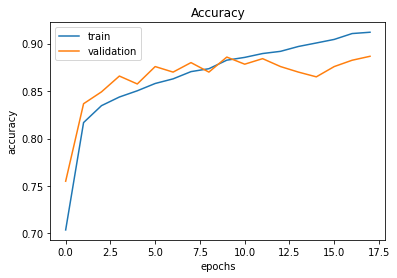

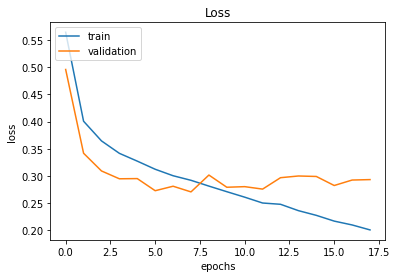

In [ ]:
#tmpdir = "/content/"
plt.figure()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig("{}/accuracy.png".format(tmpdir))

# Training and Validation Loss
plt.figure()
plt.plot(losses)
plt.plot(val_losses)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper left')
#plt.savefig("{}/loss.png".format(tmpdir))

## Testing Accuracy and Confusion Matrix
Validation Accuracy and Confusion Matrix without Test Time Augmentation

In [ ]:
# Loading the Best Model
net.load_state_dict(torch.load(model_save_dir))

<All keys matched successfully>

In [ ]:
#net.load_state_dict(torch.load('/content/drive/MyDrive/CAD/Project - 2/Challenge 2/pytorch-multiclass-models/checkpoint-epoch-{0}.pt'.format(num_epochs)))

correct = 0
total   = 0
net.eval()

with torch.no_grad():
    for data in validation_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the Network on the Validation Images: %d %%' % (
    100 * correct / total))

Accuracy of the Network on the Validation Images: 88 %


In [ ]:
confusion_matrix = torch.zeros(len(classes), len(classes))
with torch.no_grad():
    for data in validation_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix, "\n")
cm = confusion_matrix.numpy()

recall_nv = cm[0][0]/np.sum(cm[:,0])
recall_ls = cm[1][1]/np.sum(cm[:,1])

precision_nv = cm[0][0]/np.sum(cm[0])
precision_ls = cm[1][1]/np.sum(cm[1])

total = np.sum(cm)
print(total)
accuracy_nv = cm[0][0] + (total - np.sum(cm[0]) - np.sum(cm[:,0]) + cm[0][0])
accuracy_ls = cm[1][1] + (total - np.sum(cm[1]) - np.sum(cm[:,1]) + cm[1][1])

print("nv - recall : ",recall_nv, " precision : ",precision_nv, " accuracy : ",(accuracy_nv/total))
print("ls - recall : ",recall_ls, " precision : ",precision_ls, " accuracy : ",(accuracy_ls/total))

tensor([[538.,  62.],
        [ 82., 518.]]) 

1200.0
nv - recall :  0.86774194  precision :  0.89666665  accuracy :  0.88
ls - recall :  0.8931034  precision :  0.86333334  accuracy :  0.88


0.88


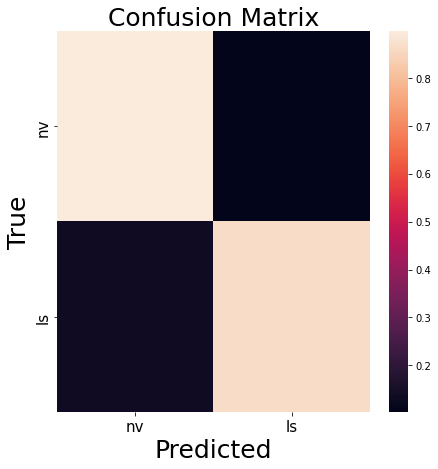

In [ ]:
fig,ax= plt.subplots(figsize=(7,7))
sns.heatmap(cm / (cm.astype(np.float).sum(axis=1) + 1e-9), annot=False, ax=ax)

# Labels, Title and Ticks
ax.set_xlabel('Predicted', size=25);
ax.set_ylabel('True', size=25); 
ax.set_title('Confusion Matrix', size=25); 
ax.xaxis.set_ticklabels(['nv','ls'], size=15); 
ax.yaxis.set_ticklabels(['nv','ls'], size=15);
print(correct/total)